## 의존성 모듈 설정

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dart_fss as dart_fss
import numpy as np
from matplotlib import font_manager
import platform
import os,sys

## Path 설정

In [163]:
project_path = os.getcwd()  # 현재 작업 디렉토리 경로
sys.path.append(project_path)  # PYTHONPATH에 추가

## OS 폰트 설정

In [164]:
if platform.system() == 'Linux':  # 우분투
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
elif platform.system() == 'Darwin':  # 맥
    font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

font = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font
plt.rcParams['axes.unicode_minus'] = False  

## 한전 영업실적 분석

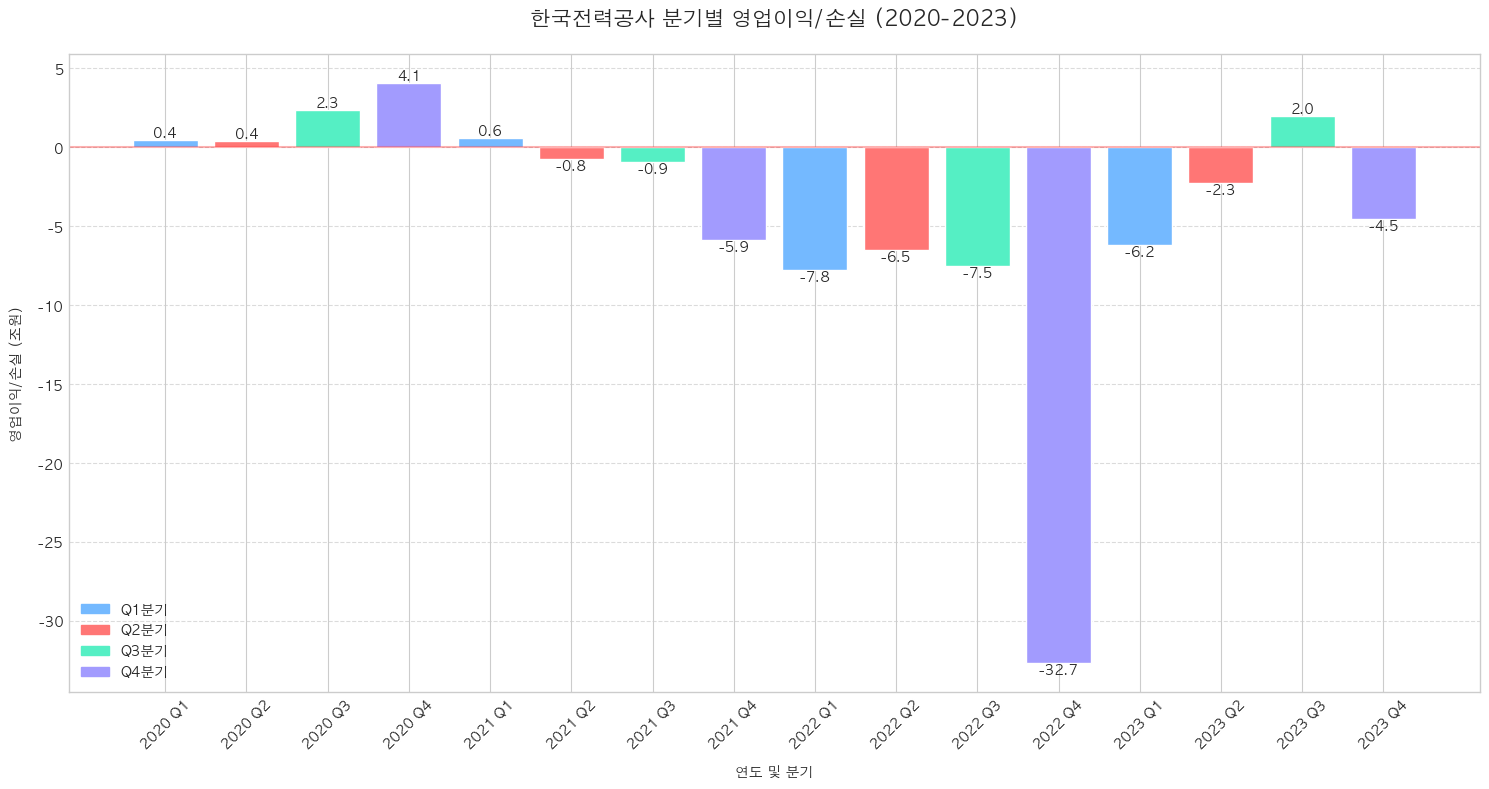

In [165]:
api_key = 'de9b40bac8ef03b5109f2a6d78ab2041e9185ad1'
dart_fss.set_api_key(api_key=api_key)
corp_list = dart_fss.get_corp_list()
kepco = corp_list.find_by_corp_name('한국전력공사', exactly=True)[0]
corp_code = kepco.corp_code

years = ['2020', '2021', '2022', '2023']
quarters = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

results = []
for year in years:
    for quarter, report_code in quarters.items():
        try:
            data = dart_fss.api.finance.fnltt_singl_acnt_all(
                corp_code=corp_code,
                bsns_year=year,
                reprt_code=report_code,
                fs_div='CFS',
                api_key=api_key
            )['list']
            
            for item in data:
                if item['account_nm'] == '영업이익(손실)':
                    amount = int(item['thstrm_amount'])
                    results.append({
                        'Year': year,
                        'Quarter': quarter,
                        'Operating_PL': amount
                    })
                    break
        except Exception as e:
            print(f"Error fetching data for {year} {quarter}: {str(e)}")

# 데이터프레임 생성 및 단위 변환
operating_pl = pd.DataFrame(results)
operating_pl['Operating_PL_Trillion'] = operating_pl['Operating_PL'] / 1_000_000_000_000
operating_pl['Period'] = operating_pl['Year'] + ' ' + operating_pl['Quarter']

# 분기별 색상 매핑 (계절성 표현)
quarter_colors = {'Q1': '#74b9ff', 'Q2': '#ff7675', 'Q3': '#55efc4', 'Q4': '#a29bfe'}
bar_colors = [quarter_colors[q] for q in operating_pl['Quarter']]

# 그래프 생성
plt.figure(figsize=(15, 8))
bars = plt.bar(operating_pl['Period'], operating_pl['Operating_PL_Trillion'], color=bar_colors)

# 그래프 스타일링
plt.title('한국전력공사 분기별 영업이익/손실 (2020-2023)', pad=20, size=15)
plt.xlabel('연도 및 분기', labelpad=10)
plt.ylabel('영업이익/손실 (조원)', labelpad=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 0선 추가
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# 데이터 레이블 추가
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom' if height > 0 else 'top')

# 범례 추가
legend_elements = [plt.Rectangle((0,0),1,1, color=color, label=f'{quarter}분기') 
                  for quarter, color in quarter_colors.items()]
plt.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()

# 그래프 저장
plt.savefig('graph/한전_분기별_영업손실.png', dpi=300, bbox_inches='tight')
plt.show()

## 계절별 전력 수요 분석

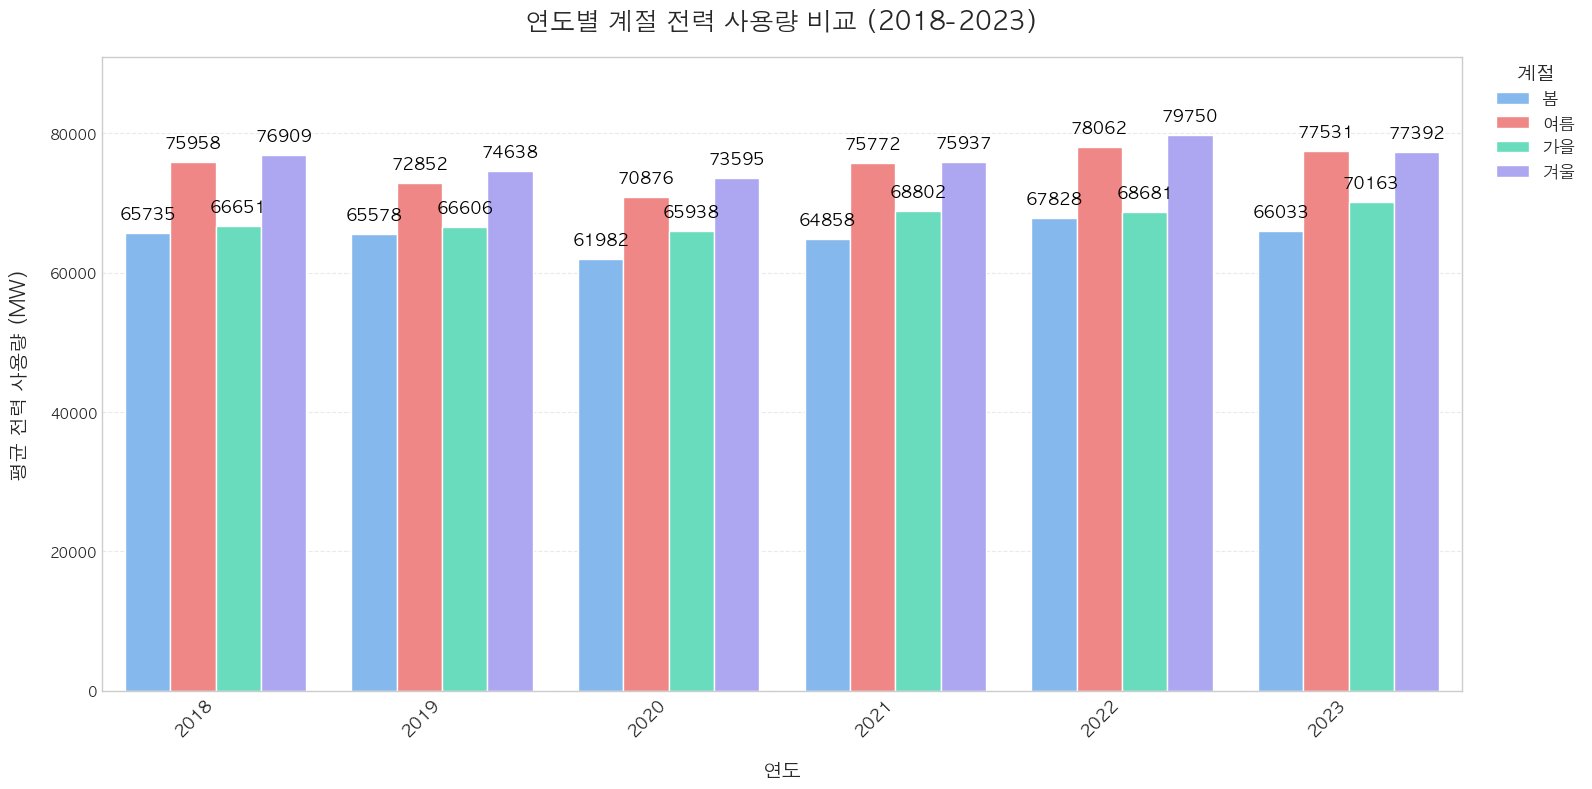

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 계절 매핑
seasons = {
    '1월': '겨울', '2월': '겨울', '3월': '봄', '4월': '봄', '5월': '봄',
    '6월': '여름', '7월': '여름', '8월': '여름', '9월': '가을', '10월': '가을',
    '11월': '가을', '12월': '겨울'
}

# 데이터 읽기 및 전처리
monthly_power = pd.read_csv('data/월별평균최대전력.csv', encoding='euc-kr')
monthly_power_melted = monthly_power.melt(id_vars=['연도'], 
                                           value_vars=[col for col in monthly_power.columns if col != '연도'],
                                           var_name='월', value_name='최대전력')
monthly_power_melted['계절'] = monthly_power_melted['월'].map(seasons)

# 계절별 색상 지정 (한전 그래프와 동일한 색상 스타일)
season_colors = {
    '봄': '#74b9ff',    # 하늘색
    '여름': '#ff7675',  # 붉은색
    '가을': '#55efc4',  # 민트색
    '겨울': '#a29bfe'   # 보라색
}

# 그래프 생성
plt.figure(figsize=(16, 8))

# 바 플롯 생성
bars = sns.barplot(data=monthly_power_melted, x='연도', y='최대전력', 
                  hue='계절', hue_order=['봄', '여름', '가을', '겨울'],
                  palette=season_colors, errorbar=None)

# 그래프 스타일링
plt.title('연도별 계절 전력 사용량 비교 (2018-2023)', pad=20, size=18, weight='bold')
plt.xlabel('연도', labelpad=15, size=14)
plt.ylabel('평균 전력 사용량 (MW)', labelpad=15, size=14)

# 그리드 추가
plt.grid(axis='y', linestyle='--', alpha=0.4)

# y축 범위 설정
plt.ylim(0, monthly_power_melted['최대전력'].max() * 1.1)

# 범례 위치 조정 및 스타일링
plt.legend(title='계절', title_fontsize=14,
          bbox_to_anchor=(1.02, 1), loc='upper left',
          borderaxespad=0, fontsize=12)

# 데이터 레이블 추가
for container in bars.containers:
    bars.bar_label(container, fmt='%.0f', padding=8, rotation=0, fontsize=12, color='black')

# x축 레이블 회전
plt.xticks(rotation=45, ha='right', fontsize=12)

# 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('graph/계절별_전력사용량_개선.png', dpi=300, bbox_inches='tight')
plt.show()


## 발전원별 발전설비 분석

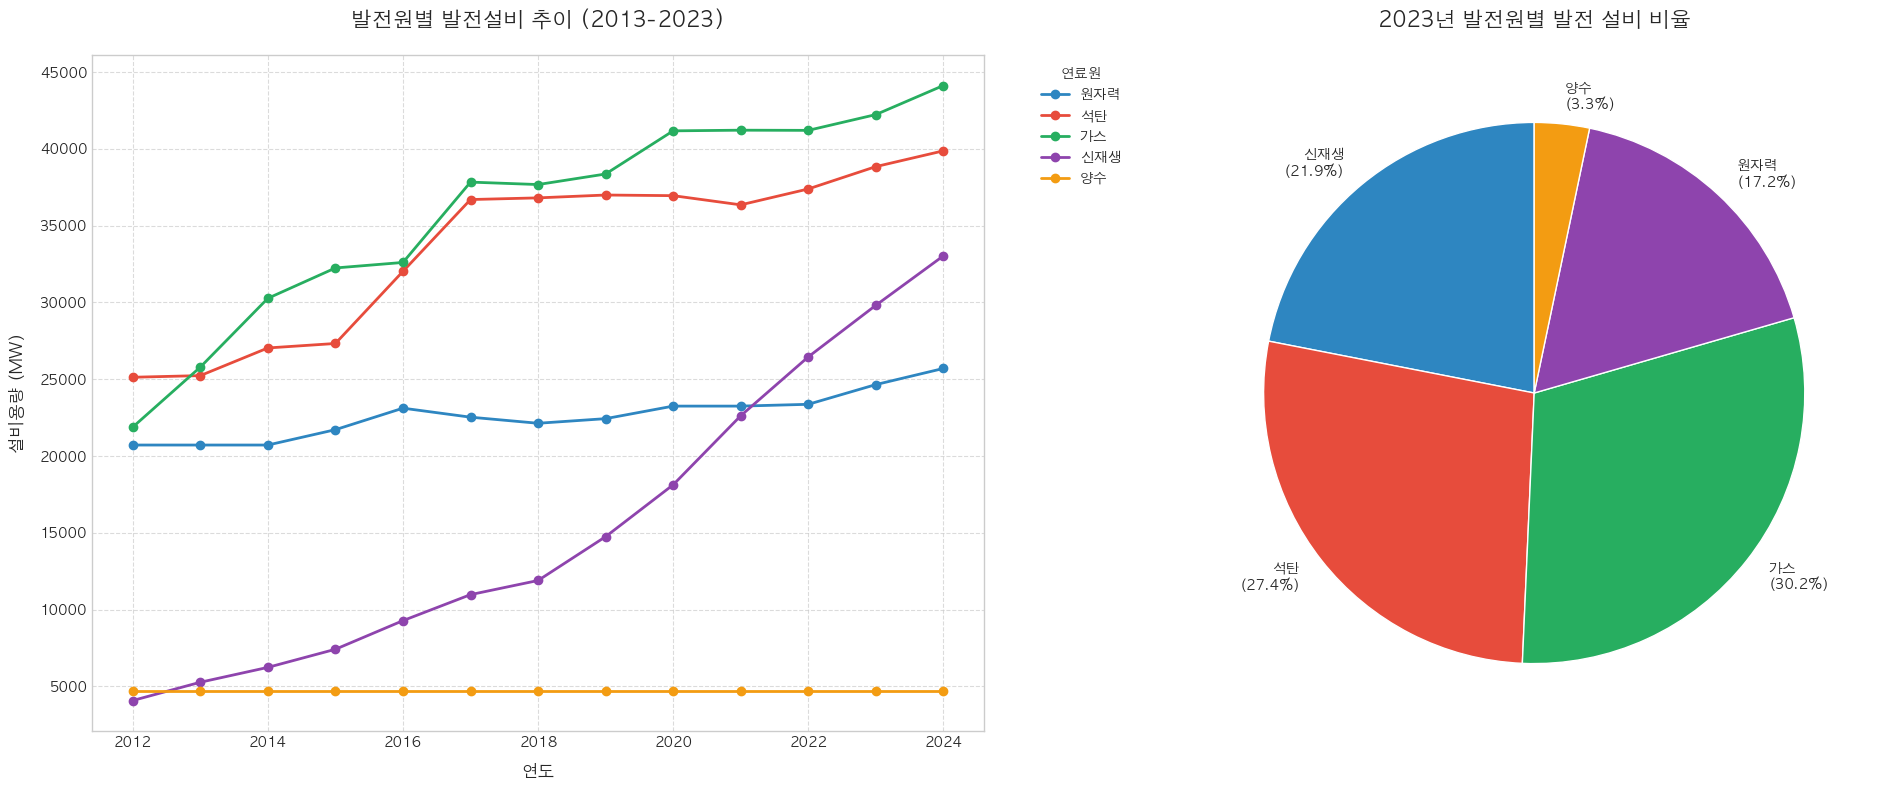

In [167]:
# 데이터 불러오기 및 전처리
df = pd.read_csv('data/발전원별_발전설비.csv', encoding='euc-kr')

# 데이터 전처리
df['석탄'] = df['유연탄'] + df['무연탄']
df['가스'] = df['기력/가스'] + df['복합화력/가스'] + df['내연력/가스']
df['유류'] = df['기력/유류'] + df['복합화력/유류'] + df['내연력/유류']
df = df.drop(columns=['기력/유류', '기력/가스', '유연탄', '무연탄',
                     '복합화력/가스', '복합화력/유류', '내연력/가스', '내연력/유류'])

# 연도 추출
df['년도'] = pd.to_datetime(df['기간'], format='%b.%y').dt.year

# 서브플롯 생성 (1x2 구조)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 색상 설정
colors = ['#2E86C1', '#E74C3C', '#27AE60', '#8E44AD', '#F39C12']
columns = ['원자력', '석탄', '가스', '신재생', '양수']

# 1. 연료별 발전 추이 그래프 
yearly_data = df.groupby('년도')[columns].mean()

for i, col in enumerate(columns):
    ax1.plot(yearly_data.index, yearly_data[col], 
             marker='o', linewidth=2, label=col, color=colors[i])

ax1.set_title('발전원별 발전설비 추이 (2013-2023)', pad=20, size=15, weight='bold')
ax1.set_xlabel('연도', labelpad=10, size=12)
ax1.set_ylabel('설비용량 (MW)', labelpad=10, size=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(title='연료원', bbox_to_anchor=(1.05, 1))

# 2. 2023년 연료별 비율 파이 차트 
data_2023 = df[df['년도'] == 2023].iloc[0]
fuel_data = {
    '신재생': data_2023['신재생'],
    '석탄': data_2023['석탄'],
    '가스': data_2023['가스'],
    '원자력': data_2023['원자력'],
    '양수': data_2023['양수']
}

# 비율 계산
total = sum(fuel_data.values())
fuel_percentages = {k: (v/total)*100 for k, v in fuel_data.items()}

# 파이 차트 그리기
ax2.pie(fuel_percentages.values(), 
        labels=[f'{k}\n({v:.1f}%)' for k, v in fuel_percentages.items()],
        colors=colors,
        autopct='',
        startangle=90)

ax2.set_title('2023년 발전원별 발전 설비 비율', pad=20, size=15, weight='bold')

# 전체 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('graph/발전원별_발전설비.png', dpi=300, bbox_inches='tight')
plt.show()

## 발전형식별 발전량 분석

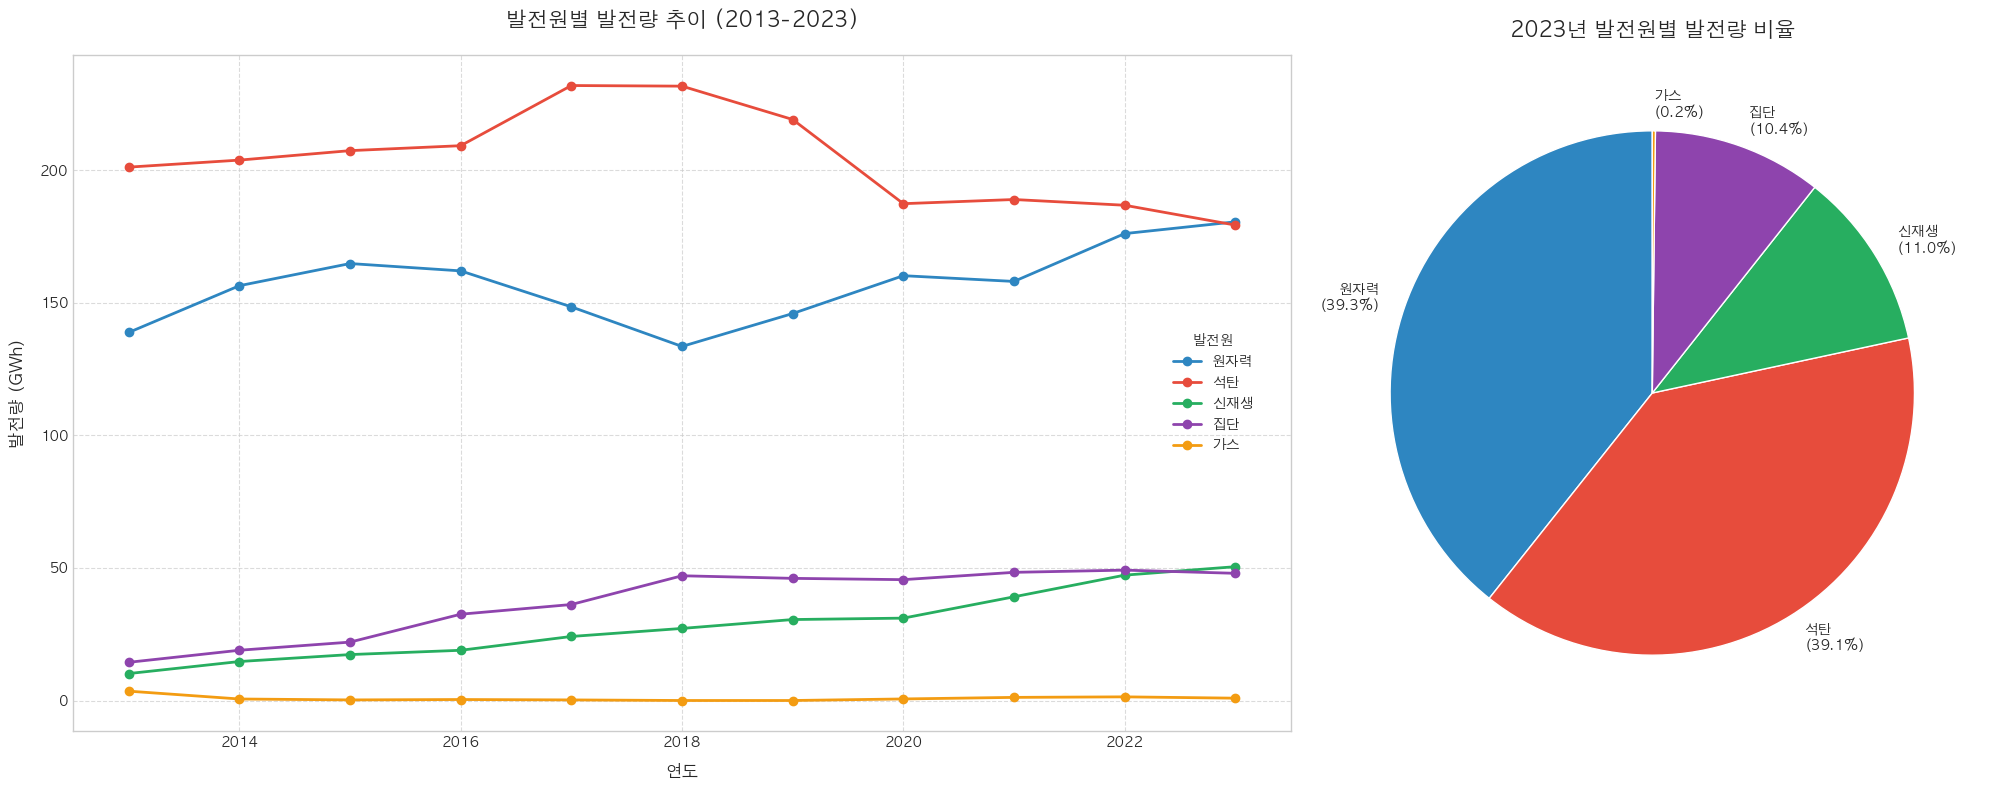

In [168]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('data/발전원별_발전량.csv', encoding='euc-kr')

# 데이터 전처리
df['석탄'] = df['유연탄'] + df['무연탄']
df = df.drop(columns=['유연탄', '무연탄'])

# 서브플롯 생성 (1x2 구조)
fig = plt.figure(figsize=(20, 8))
gs = plt.GridSpec(1, 2, width_ratios=[1.3, 0.7])  # 왼쪽 그래프 비율 증가
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# 색상 설정
colors = ['#2E86C1', '#E74C3C', '#27AE60', '#8E44AD', '#F39C12']

# 상위 5개 발전원 선택 (2023년 기준)
top_sources = ['원자력', '석탄', '신재생', '집단', '가스']

# 1. 발전원별 발전량 추이 그래프 (왼쪽)
for i, source in enumerate(top_sources):
    ax1.plot(df['연도'], df[source] / 1000000,  # GWh 단위로 변환
             marker='o', linewidth=2, label=source, color=colors[i])

ax1.set_title('발전원별 발전량 추이 (2013-2023)', pad=20, size=15, weight='bold')
ax1.set_xlabel('연도', labelpad=10, size=12)
ax1.set_ylabel('발전량 (GWh)', labelpad=10, size=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# 범례 위치 
ax1.legend(title='발전원', loc='center right', bbox_to_anchor=(0.98, 0.5))

# y축 단위 표시 형식 변경
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 2. 2023년 발전원별 비율 파이 차트 (오른쪽)
data_2023 = df[df['연도'] == 2023].iloc[0]
generation_data = {source: data_2023[source] for source in top_sources}

# 비율 계산
total = sum(generation_data.values())
generation_percentages = {k: (v/total)*100 for k, v in generation_data.items()}

# 파이 차트 그리기
wedges, texts = ax2.pie(generation_percentages.values(), 
                        labels=[f'{k}\n({v:.1f}%)' for k, v in generation_percentages.items()],
                        colors=colors,
                        startangle=90)

# 파이 차트 스타일링
plt.setp(texts, size=10, weight='bold')

ax2.set_title('2023년 발전원별 발전량 비율', pad=20, size=15, weight='bold')

# 전체 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('graph/발전원별_발전량.png', dpi=300, bbox_inches='tight')
plt.show()


## LNG 발전, SMP, 한전 적자 관계 분석

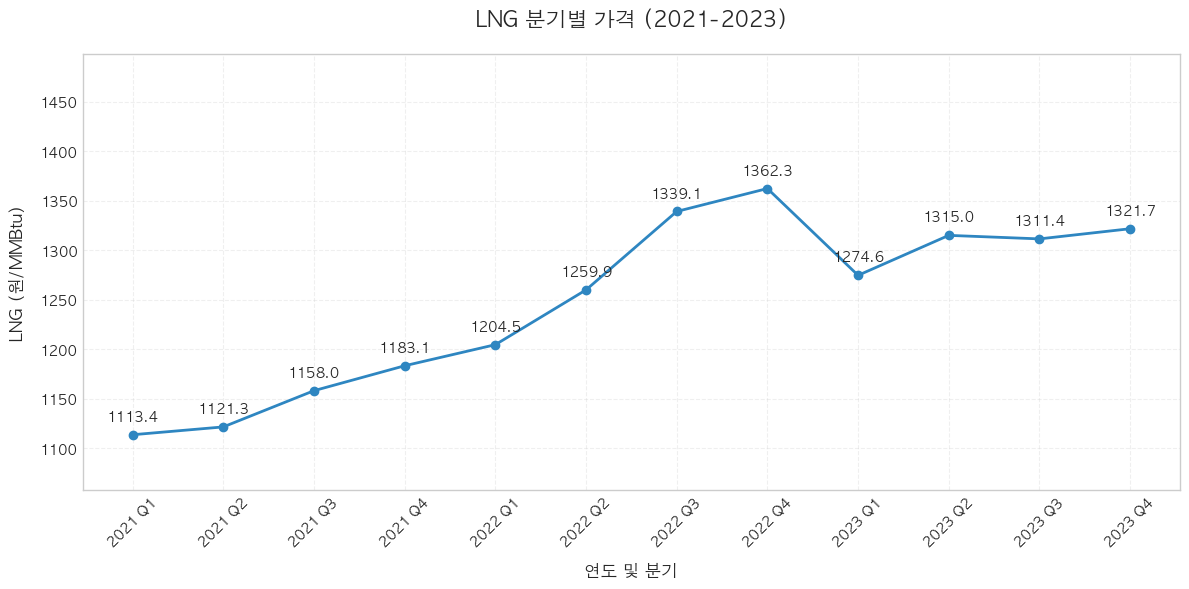

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리
monthly_LNG['연월일'] = pd.to_datetime(monthly_LNG['연월일'])
monthly_LNG['연도'] = monthly_LNG['연월일'].dt.year
monthly_LNG['분기'] = monthly_LNG['연월일'].dt.quarter.map({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'})

# 2021-2023년 데이터 필터링 및 분기별 평균 계산
quarterly_exchange = monthly_LNG[monthly_LNG['연도'].isin([2021, 2022, 2023])].groupby(['연도', '분기'])['환율(원달러)'].mean().reset_index()
quarterly_exchange['Period'] = quarterly_exchange['연도'].astype(str) + ' ' + quarterly_exchange['분기']

# 그래프 생성
plt.figure(figsize=(12, 6))

# 데이터의 최대값 확인
max_value = quarterly_exchange['환율(원달러)'].max()

# 꺾은선 그래프 그리기
plt.plot(quarterly_exchange['Period'], quarterly_exchange['환율(원달러)'], 
         marker='o', linewidth=2, color='#2E86C1')

# y축 범위 설정 (최대값보다 10% 더 높게 설정)
plt.ylim(quarterly_exchange['환율(원달러)'].min() * 0.95, max_value * 1.1)

# 그래프 스타일링
plt.title('LNG 분기별 가격 (2021-2023)', pad=20, size=15, weight='bold')
plt.xlabel('연도 및 분기', labelpad=10, size=12)
plt.ylabel('LNG (원/MMBtu)', labelpad=10, size=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)

# 데이터 레이블 추가
for x, y in zip(quarterly_exchange['Period'], quarterly_exchange['환율(원달러)']):
    plt.annotate(f'{y:.1f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

# 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('graph/분기별_LNG_가격_추이.png', dpi=300, bbox_inches='tight')
plt.show()

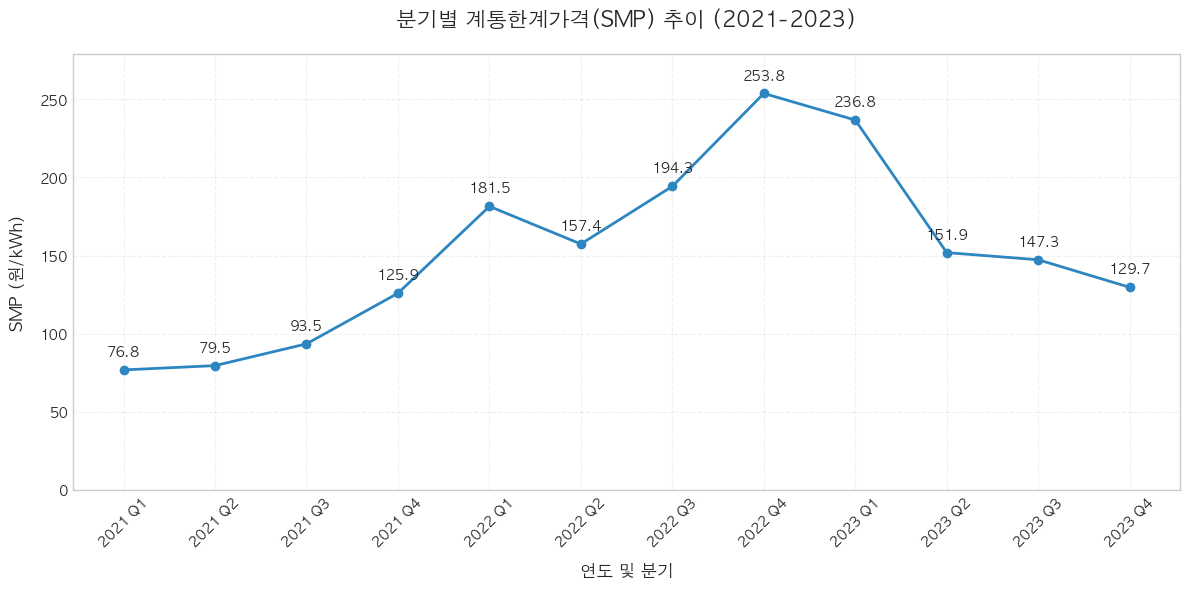

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 전처리
def parse_period(period):
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    
    month_str, year_str = period.split('.')
    month = month_map[month_str]
    year = 2000 + int(year_str)  # '23' -> 2023
    return year, month

# 연도와 분기 추출
monthly_SMP[['연도', '월']] = monthly_SMP['기간'].apply(lambda x: pd.Series(parse_period(x)))
monthly_SMP['분기'] = monthly_SMP['월'].apply(lambda x: f'Q{(x-1)//3 + 1}')

# 2021-2023년 데이터 필터링 및 분기별 평균 계산
quarterly_SMP = monthly_SMP[monthly_SMP['연도'].isin([2021, 2022, 2023])].groupby(['연도', '분기'])['통합'].mean().reset_index()
quarterly_SMP['Period'] = quarterly_SMP['연도'].astype(str) + ' ' + quarterly_SMP['분기']

# 그래프 생성
plt.figure(figsize=(12, 6))

# 데이터의 최대값 확인
max_value = quarterly_SMP['통합'].max()

# 꺾은선 그래프 그리기
plt.plot(quarterly_SMP['Period'], quarterly_SMP['통합'], 
         marker='o', linewidth=2, color='#2E86C1')

# y축 범위 설정
plt.ylim(0, max_value * 1.1)

# 그래프 스타일링
plt.title('분기별 계통한계가격(SMP) 추이 (2021-2023)', pad=20, size=15, weight='bold')
plt.xlabel('연도 및 분기', labelpad=10, size=12)
plt.ylabel('SMP (원/kWh)', labelpad=10, size=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)

# 데이터 레이블 추가
for x, y in zip(quarterly_SMP['Period'], quarterly_SMP['통합']):
    plt.annotate(f'{y:.1f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

# 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('graph/분기별_SMP_가격_추이.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/2z/9c212f252mzbqjpgk8v9v7qw0000gn/T/ipykernel_88829/2621470535.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(quarterly_exchange['Period'], rotation=45, ha='right', fontsize=12)


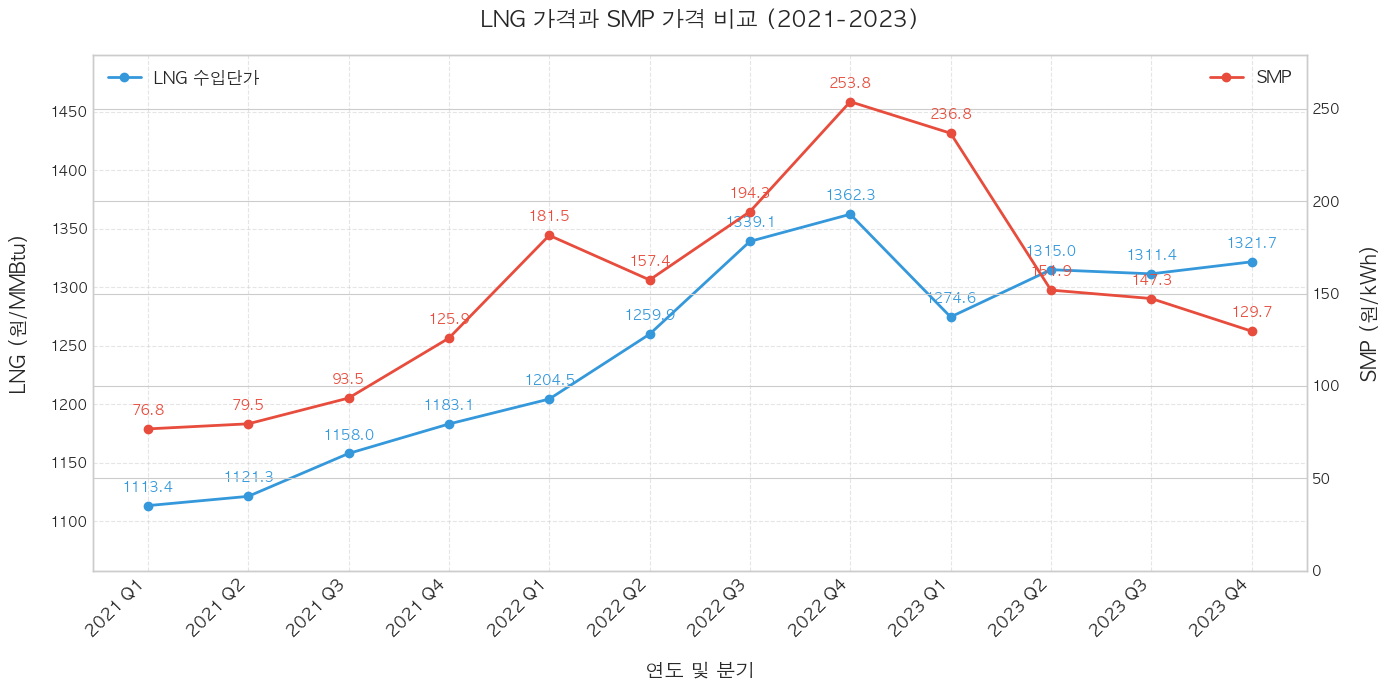

In [171]:
# 데이터 전처리 (LNG 가격 데이터)
monthly_LNG['연월일'] = pd.to_datetime(monthly_LNG['연월일'])
monthly_LNG['연도'] = monthly_LNG['연월일'].dt.year
monthly_LNG['분기'] = monthly_LNG['연월일'].dt.quarter.map({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'})

# 2021-2023년 데이터 필터링 및 분기별 평균 계산
quarterly_exchange = monthly_LNG[monthly_LNG['연도'].isin([2021, 2022, 2023])].groupby(['연도', '분기'])['환율(원달러)'].mean().reset_index()
quarterly_exchange['Period'] = quarterly_exchange['연도'].astype(str) + ' ' + quarterly_exchange['분기']

# 데이터 전처리 (SMP 가격 데이터)
def parse_period(period):
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    
    month_str, year_str = period.split('.')
    month = month_map[month_str]
    year = 2000 + int(year_str)  # '23' -> 2023
    return year, month

# 연도와 분기 추출
monthly_SMP[['연도', '월']] = monthly_SMP['기간'].apply(lambda x: pd.Series(parse_period(x)))
monthly_SMP['분기'] = monthly_SMP['월'].apply(lambda x: f'Q{(x-1)//3 + 1}')

# 2021-2023년 데이터 필터링 및 분기별 평균 계산
quarterly_SMP = monthly_SMP[monthly_SMP['연도'].isin([2021, 2022, 2023])].groupby(['연도', '분기'])['통합'].mean().reset_index()
quarterly_SMP['Period'] = quarterly_SMP['연도'].astype(str) + ' ' + quarterly_SMP['분기']

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(14, 7))

# 첫 번째 y축 (환율(원달러)) - LNG 가격
ax1.set_xlabel('연도 및 분기', labelpad=15, size=14)
ax1.set_ylabel('LNG (원/MMBtu)', labelpad=15, size=14)
ax1.plot(quarterly_exchange['Period'], quarterly_exchange['환율(원달러)'], 
         marker='o', linewidth=2, color='#3498db', label='LNG 수입단가')
ax1.set_ylim(quarterly_exchange['환율(원달러)'].min() * 0.95, quarterly_exchange['환율(원달러)'].max() * 1.1)
ax1.grid(True, linestyle='--', alpha=0.5)

# 데이터 레이블 추가 (LNG 가격)
for x, y in zip(quarterly_exchange['Period'], quarterly_exchange['환율(원달러)']):
    ax1.annotate(f'{y:.1f}', 
                 (x, y), 
                 textcoords="offset points", 
                 xytext=(0, 10), 
                 ha='center', fontsize=10, color='#3498db')

# 두 번째 y축 (SMP 가격)
ax2 = ax1.twinx()
ax2.set_ylabel('SMP (원/kWh)', labelpad=15, size=14)
ax2.plot(quarterly_SMP['Period'], quarterly_SMP['통합'], 
         marker='o', linewidth=2, color='#e74c3c', label='SMP')
ax2.set_ylim(0, quarterly_SMP['통합'].max() * 1.1)

# 데이터 레이블 추가 (SMP 가격)
for x, y in zip(quarterly_SMP['Period'], quarterly_SMP['통합']):
    ax2.annotate(f'{y:.1f}', 
                 (x, y), 
                 textcoords="offset points", 
                 xytext=(0, 10), 
                 ha='center', fontsize=10, color='#e74c3c')

# 그래프 스타일링
ax1.set_title('LNG 가격과 SMP 가격 비교 (2021-2023)', pad=20, size=16, weight='bold')
ax1.set_xticklabels(quarterly_exchange['Period'], rotation=45, ha='right', fontsize=12)

# 범례 추가
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# 레이아웃 조정
plt.tight_layout()

# 그래프 저장
plt.savefig('graph/분기별_LNG_SMP_가격_비교.png', dpi=300, bbox_inches='tight')
plt.show()
